<a href="https://colab.research.google.com/github/JaleelSavoy/DeepLearningPracticeProjects/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
def load_image(path_to_image, max_dim=1024):
  '''Load image from from file path and decode, convert and resize it'''
  image = tf.image.decode_image(tf.io.read_file(path_to_image))
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  scale = max_dim/max(shape)
  new_shape = tf.cast(shape*scale, tf.int32)
 
  image = tf.image.resize(image, new_shape)[tf.newaxis, :]
  return(image)

def vgg_layers(layer_names):
  '''pre-trained VGG19 for the neural style transfer'''
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  '''gram matrix to get the style of the style image'''
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss
  
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
# get the images
content_image_path = tf.keras.utils.get_file('content.jpg','https://external-preview.redd.it/jKJOV7ldoTBulur_rFtdBsNPW2Lrum0n0As0sMyumAI.jpg?auto=webp&s=2bc4d3aaf8d7613d5c1f956173c9be91b2cb449c')
style_image_path = tf.keras.utils.get_file('style.jpg','https://theculturetrip.com/wp-content/uploads/2017/01/image11.jpg')
  
image_content = load_image(content_image_path)
image_style = load_image(style_image_path)

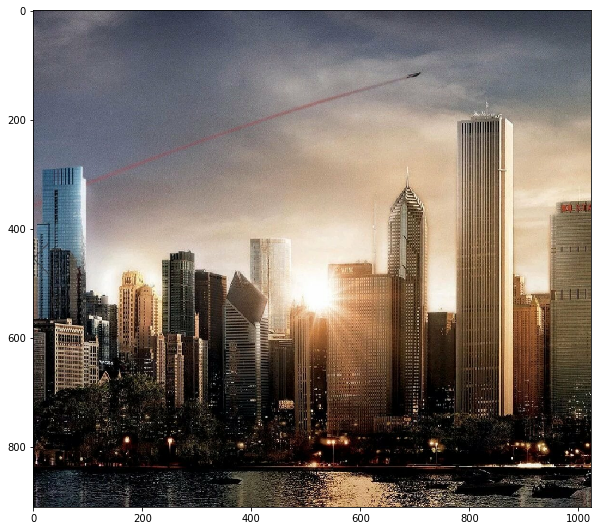

In [4]:
# plot the content image
plt.figure(figsize=(10,10))
plt.imshow(tf.squeeze(image_content, axis=0))

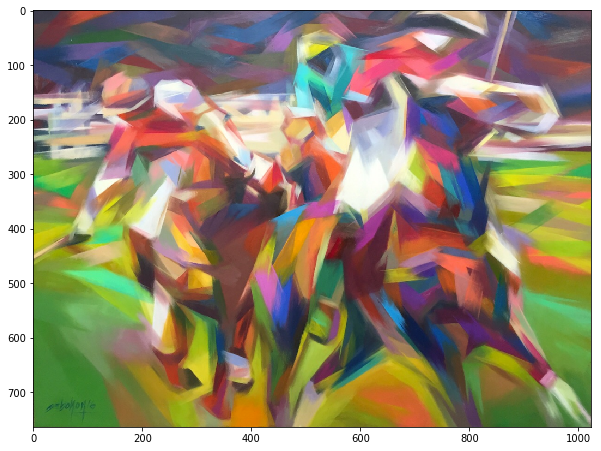

In [5]:
# plot the style image
plt.figure(figsize=(10,10))
plt.imshow(tf.squeeze(image_style, axis=0))

In [6]:
x = tf.image.resize(tf.keras.applications.vgg19.preprocess_input(image_content*255),(224,224))
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 33s 0us/step


In [7]:
for i in vgg.layers:
  print(i.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(image_style*255)

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(image_content))

style_results = results['style']

style_targets = extractor(image_style)['style']
content_targets = extractor(image_content)['content']

image = tf.Variable(image_content)

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

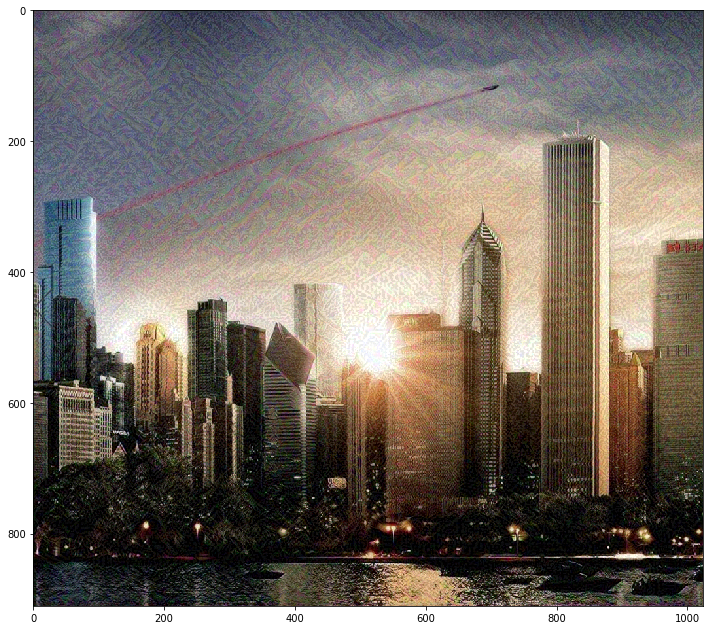

In [13]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

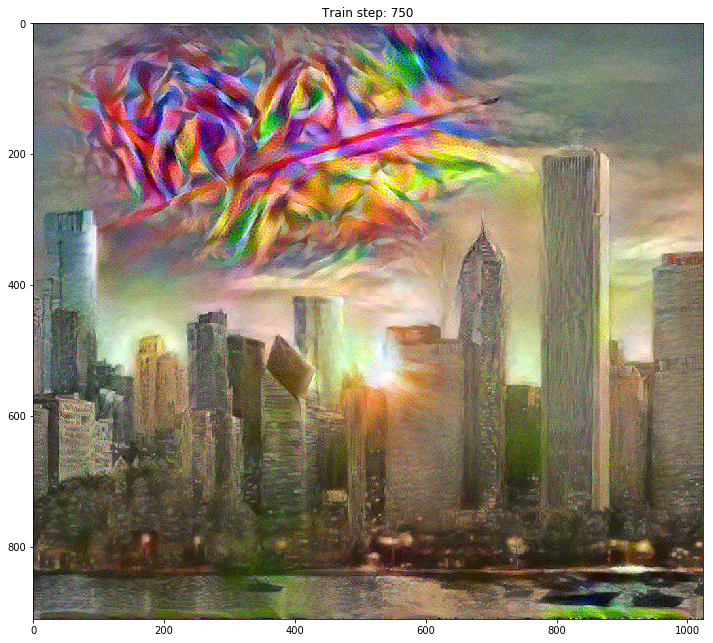

Total time: 258.2


In [14]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 75

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  plt.imshow(tf.squeeze(image.read_value(), axis=0))
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))